In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sgmca import sgmca
import utils

np.random.seed(1)
plt.rcParams.update({'font.size': 16})

In [2]:
n = 4                                # number of sources
m = 75                               # number of channels
p = 346**2                           # number of samples
snr = 40                             # data Signat-to-Noise Ratio in dB
models = {"data/model_sync": 1,      # IAE model of the synchrotron component
          "data/model_thermal": 1,   # IAE model of the thermal component
          "data/model_gauss": 2}     # IAE model of the 2 Gaussian components
verb = 0                             # verbosity (0: mute, 5: very talkative)

In [3]:
# Load sources

S0 = np.zeros((n, p))
data = np.load("data/sources.pkl", allow_pickle=True)
for i, key in enumerate(data.keys()):
    S0[i, :] = data[key].flatten()
S0 /= np.linalg.norm(S0, axis=1)[:, np.newaxis]
del data

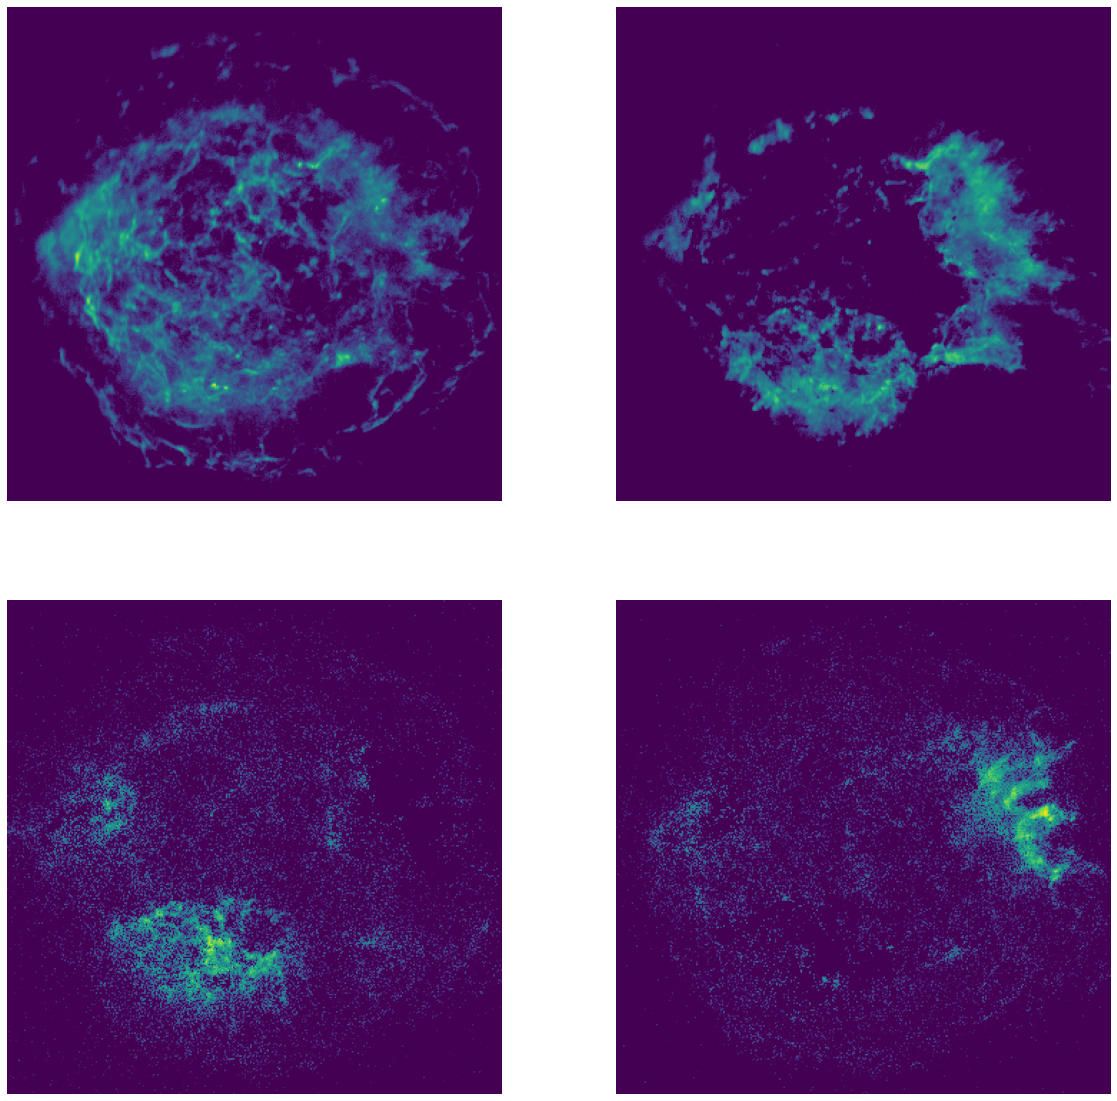

In [4]:
# Plot sources

size = np.int(np.sqrt(p))
vmin = 1e-3
vmax = np.max(S0)

def f(x):
    return np.log10(np.maximum(vmin, x))

fig = plt.figure(figsize=(20,20))
for i, j in enumerate(range(221, 225)):
    fig.add_subplot(j)
    plt.imshow(np.reshape(f(S0[i, :]), (size, size)), vmin=f(vmin), vmax=f(vmax))
    plt.gca().set_axis_off()

In [5]:
# Load mixing matrix

A0 = np.zeros((m, n))
data = np.load('data/spectra_sync.npz')['test']
A0[:, 0] = data[np.random.choice(np.shape(data)[0]), :]
data = np.load('data/spectra_thermal.npz')['test']
A0[:, 1] = data[np.random.choice(np.shape(data)[0]), :]
data = np.load('data/spectra_iron.npz')['test']
A0[:, 2:] = data[np.random.choice(np.shape(data)[0], size=2, replace=False), :].T

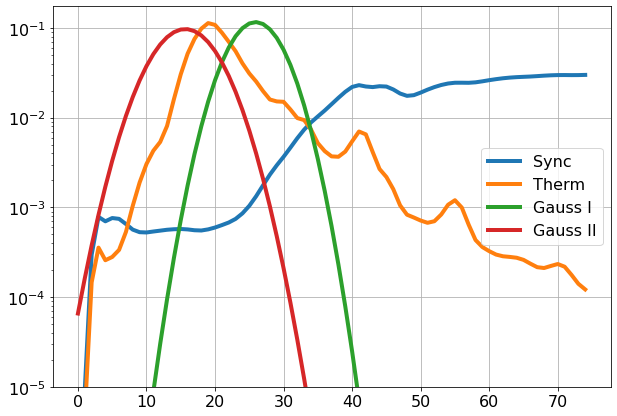

In [6]:
# Plot mixing matrix

labels = ['Sync', 'Therm', 'Gauss I', 'Gauss II']

plt.figure(figsize=(10,7))
for i in range(n):
    plt.semilogy(A0[:, i], linewidth=4, label=labels[i])
plt.ylim((1e-5, 1.5*np.max(A0)))
plt.grid()
plt.legend();

In [7]:
# Generate data
X = A0@S0
N = np.random.randn(m, p) * np.sqrt(np.mean(X ** 2) * 10 ** (-snr / 10))
Y = X + N

nStd = np.std(N)

In [8]:
# Run sGMCA
A, S = sgmca(Y, n=n, nStd=nStd, models=models, verb=verb)

In [9]:
utils.corr_perm(A0, A, S, inplace=True)  # solve the permutation indeterminacy

In [10]:
res = utils.evaluate(A0, S0, A, S, N=N)
for i in res:
    print(i, '=', round(res[i], 2), 'dB')

SDR = 40.97 dB
SIR = 43.42 dB
SNR = 32.09 dB
SAR = 31.32 dB
SAD = 23.85 dB


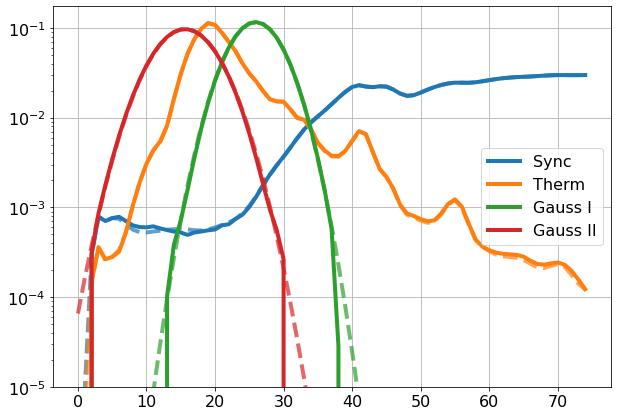

In [11]:
# Plot estimated spectra

plt.figure(figsize=(10,7))
for i in range(n):
    plt.semilogy(A0[:, i], 'C'+str(i)+'--', linewidth=4, alpha=0.7)
    plt.semilogy(A[:, i], 'C'+str(i), linewidth=4, label=labels[i])
plt.ylim((1e-5, 1.5*np.maximum(np.max(A0), np.max(A))))
plt.grid()
plt.legend();

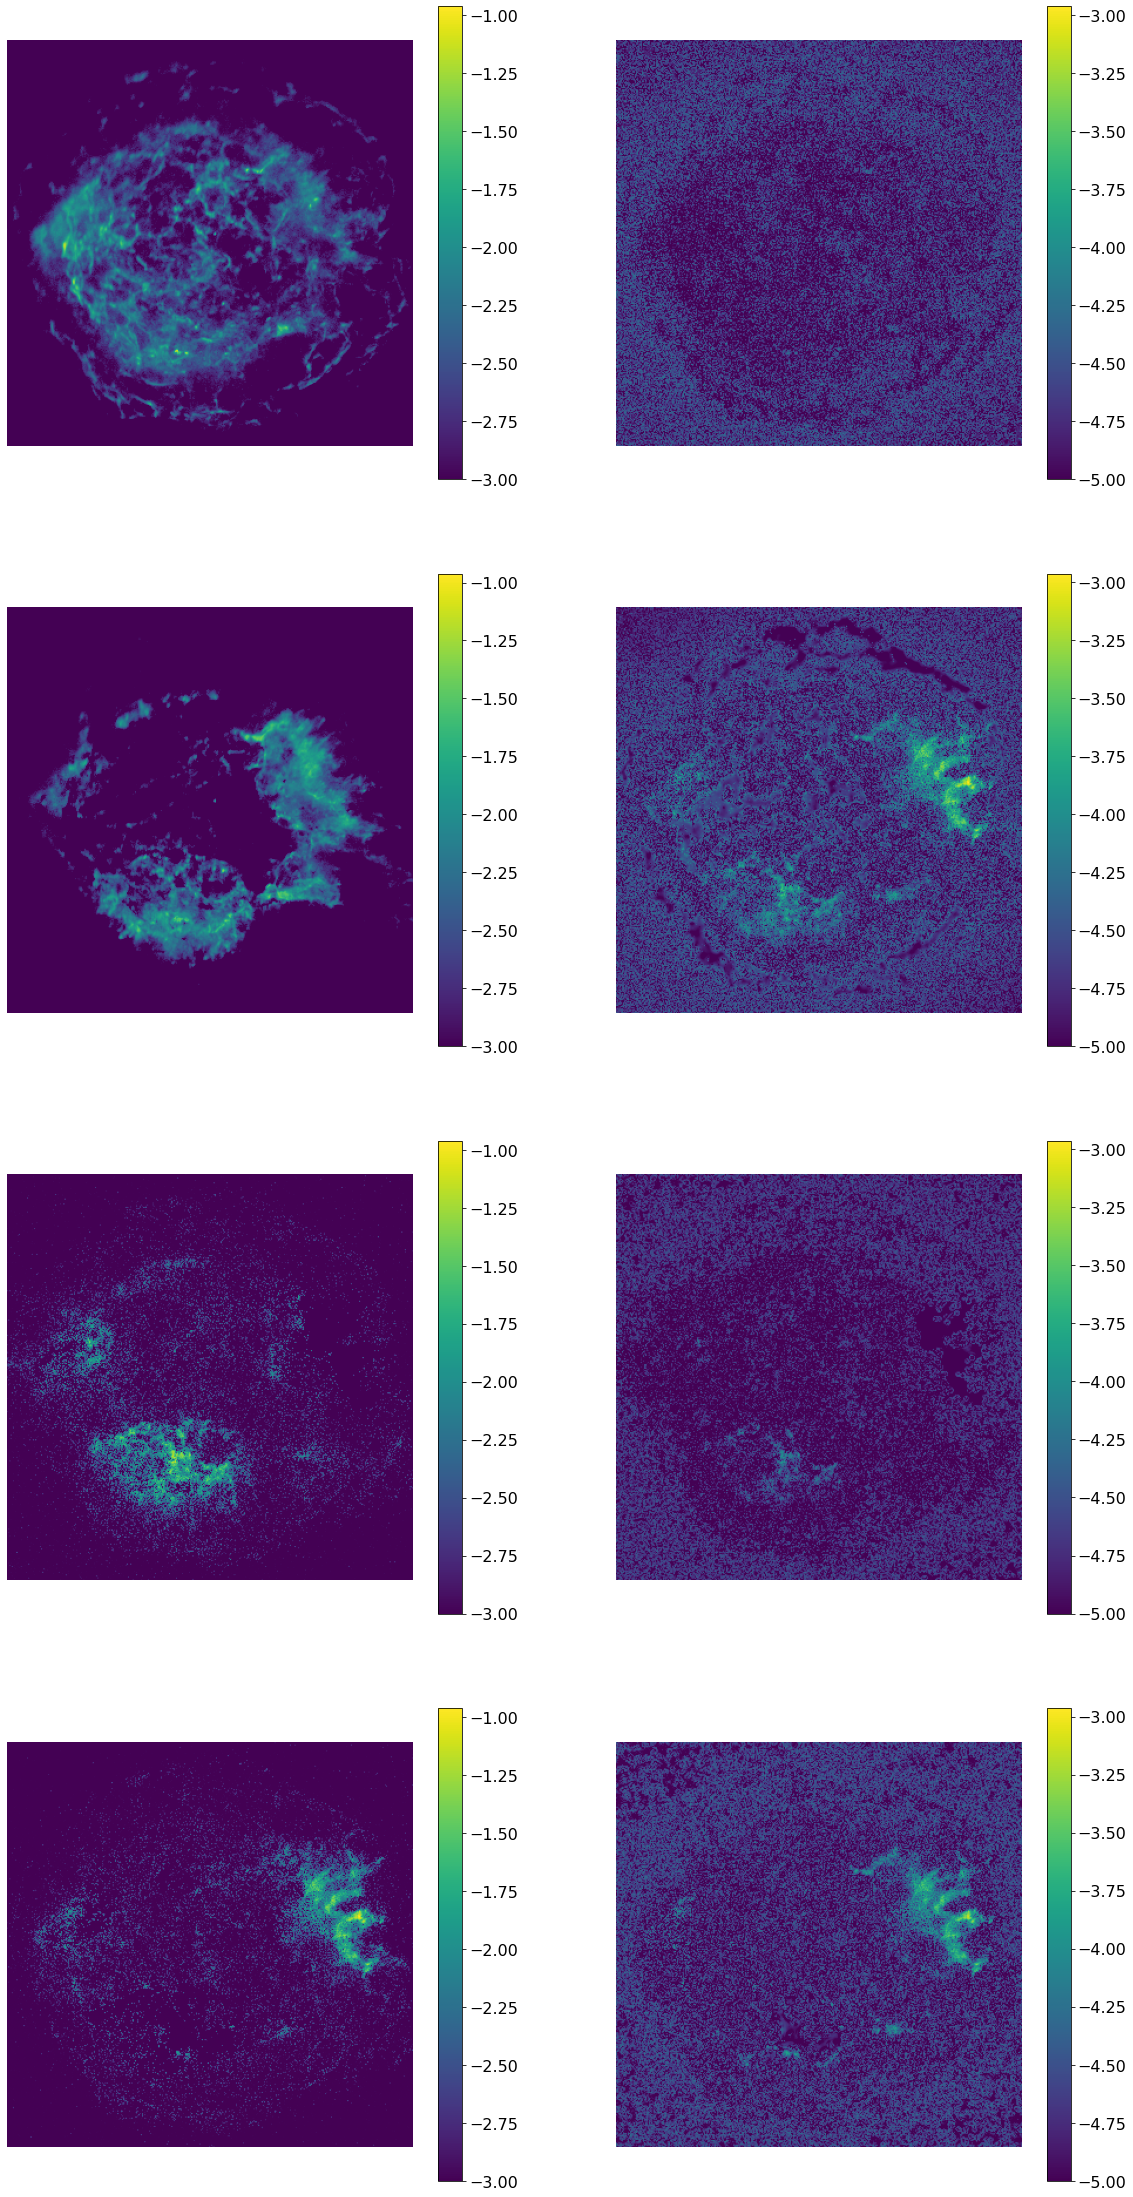

In [13]:
# Plot estimated sources and absolute errors

vmin_err = 1e-5
vmax_err = np.max(np.abs(S0-S))

def f_err(x):
    return np.log10(np.maximum(vmin_err, x))

fig = plt.figure(figsize=(20,40))
for i in range(4):
    fig.add_subplot(421+2*i)
    plt.imshow(np.reshape(f(S[i, :]), (size, size)), vmin=f(vmin), vmax=f(vmax))
    plt.gca().set_axis_off()
    plt.colorbar()
    fig.add_subplot(421+2*i+1)
    plt.imshow(np.reshape(f_err(np.abs(S[i, :]-S0[i, :])), (size, size)), vmin=f_err(vmin_err), vmax=f_err(vmax_err))
    plt.gca().set_axis_off()
    plt.colorbar()